In [1]:
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
import lib.metrics
import lib.load_data
import lib.evaluate

from lib.evaluate import testModel
from lib.load_data import get_data

import tensorflow as tf
import tensorflow_addons as tfa
#from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, model_from_json
from sklearn.model_selection import train_test_split


print('TensorFlow version: {version}'.format(version=tf.__version__))
print('Keras version: {version}'.format(version=tf.keras.__version__))
print('Eager mode enabled: {mode}'.format(mode=tf.executing_eagerly()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

2023-03-23 14:21:19.610699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.10.0
Keras version: 2.10.0
Eager mode enabled: True
Num GPUs Available:  1
Num CPUs Available:  1


In [2]:
height = 256
width = 256

root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir +os.sep + os.pardir)
print(root_dir)
path_test_levee = os.path.join(root_dir,  "datasets", "original_dataset", "test")


test_images_levee = sorted(next(os.walk(path_test_levee + "/images"))[2])

X_test, Y_test = get_data(test_images_levee, path_test_levee, height, width, train=True)


/home/mpanta1/workspace/dissertation_work/code/overall_sandboil_experiments
(51, 256, 256, 3)
Getting and resizing images ... 


100%|███████████████████████████████████████████| 51/51 [01:06<00:00,  1.30s/it]

Done!
(51, 256, 256, 3)


In [3]:
class PCALayer(tf.keras.layers.Layer):
    def __init__(self, n_components, **kwargs):
        super(PCALayer, self).__init__(**kwargs)
        self.n_components = n_components

    def build(self, input_shape):
        self.shape = input_shape
        self.input_dim = int(input_shape[-1])
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.input_dim, self.n_components), dtype="float32",
                                      initializer='glorot_uniform',
                                      trainable=False)

    def call(self, x):
        # Flatten the input tensor
        #x = tf.linalg.normalize(x,axis=-1)
        #print(x.shape)
        # assumption is that the feature vector is normalized
        #x = tf.math.l2_normalize(x, axis=-1)
        batch_size = tf.shape(x)[0]
        flattened = tf.reshape(x, [batch_size, -1, self.input_dim])
       
        # Compute the mean and subtract it from the input tensor
        mean = tf.reduce_mean(flattened, axis=1, keepdims=True)
        centered = flattened - mean
       

        # Compute the covariance matrix
        cov = tf.matmul(centered, centered, transpose_a=True) / tf.cast(tf.shape(flattened)[1] - 1, tf.float32)

        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = tf.linalg.eigh(cov)
        
        # Sort the eigenvectors based on the eigenvalues
        idx = tf.argsort(eigenvalues, axis=-1, direction='DESCENDING')
        top_eigenvectors = tf.gather(eigenvectors, idx, batch_dims=1, axis=-1)
        top_eigenvectors = top_eigenvectors[:, :, :self.n_components]

        # Transpose the eigenvectors to match the input shape
        top_eigenvectors = tf.transpose(top_eigenvectors, perm=[0, 1, 2])
       

        # Project centered data onto top principal components
        projected = tf.matmul(centered, top_eigenvectors)
        
        # Reshape projected data and return as output
        output_shape = tf.concat([tf.shape(x)[:-1], [self.n_components]], axis=0)
        #output = tf.reshape(projected, shape=(-1, *self.output_shape))
        output = tf.reshape(projected, output_shape)
        return output


    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.n_components,)

    def get_config(self):
        config = super(PCALayer, self).get_config()
        config.update({'n_components': self.n_components})
        return config

In [4]:
def evaluate_model_for_dataset(X_test, Y_test, model_name, dataset_name, custom_layer=False):
    img_height = 256
    img_width = 256    
    
    result_folder_name = str(model_name) + "_" + str(dataset_name)
    root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    model_path = os.path.join(root_dir,  "models", str(model_name), "best_model.h5")
    tf.keras.backend.clear_session()
    if custom_layer:
        best_model = tf.keras.models.load_model(model_path, custom_objects={'PCALayer': PCALayer}, compile=False)
        %time
    else:
        print("here")
        best_model = tf.keras.models.load_model(model_path,compile=False)
        
    print(f'=========Loaded {model_name} for {dataset_name}===========')
    #saveResultsOnly(best_model, X_test, 4, result_folder_name)
    results = testModel(best_model, X_test, Y_test, 4, result_folder_name)
    print("==========Evaluation Completed============")
    #print(best_model.summary())
    #return best_model


In [35]:
evaluate_model_for_dataset(X_test, Y_test,  "PCA_Spatial_Boilnet_bce_dice_loss_new", "levee", custom_layer=True) # with Adam

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 25 µs
=========Loaded PCA_Spatial_Boilnet_bce_dice_loss_new for levee===========
13/13 [==============================] - 11s 385ms/step
0.54183173
0.66736126
0.7038752 0.75655305 0.7292641
Test Jacard Index : 0.54183173
Test Dice Coefficient : 0.66736126
Test iou_all :0.5421644702706518
Test tversky : 0.6674965
Test f1_score : 0.7292641
==========Evaluation Completed============


## Plot loss and accuracy graphs for pca based models

In [6]:
import seaborn as sns
import pandas as pd

def plot_history_of_model(model_name, loss_function):
    #result_folder_name = str(model_name) + "_" + str(dataset_name)
    root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    csv_path = os.path.join(root_dir,  "models", str(model_name) + "_" + str(loss_function) , "metrics_" + str(model_name) + ".csv")
    history_df = pd.read_csv(csv_path)    
    #sns.lineplot(data=history_df[['loss', 'val_loss']].iloc[1:30, :], linewidth=2)
    
    sns.lineplot(data=history_df[['loss', 'val_loss']], linewidth=2)
    #sns.lineplot(data=history_df[['dice_coef', 'val_dice_coef']].iloc[1:30, :],  palette=['r', 'g'], linewidth=2)
    sns.lineplot(data=history_df[['dice_coef', 'val_dice_coef']],  palette=['r', 'g'], linewidth=2)


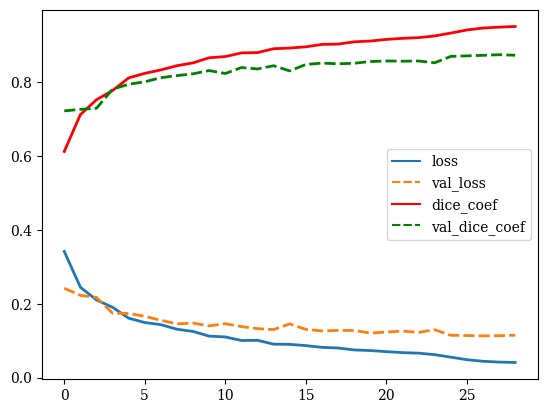

In [34]:
plot_history_of_model("PCA_Spatial_Boilnet", "bce_dice_loss_new") 